In [1]:
import re
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import numpy as np
import itertools
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score , f1_score, average_precision_score, accuracy_score
import multiprocessing
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
df_merge = pd.read_csv('full_merge.csv')
df_merge = df_merge.dropna()
print(len(df_merge))

337337


In [3]:
## remove special symbol
def rm_sym(df):
    df_merge['Reviews'] = df_merge['Reviews'].str.replace("&#039;",'\'')
    df_merge['rating_category'] = ''
    df_merge.loc[df_merge['Rating'] >= 7,'rating_category'] = 'Positive'
    df_merge.loc[(df_merge['Rating'] > 4) & (df_merge['Rating'] < 7),'rating_category'] = 'Neutral'
    df_merge.loc[df_merge['Rating'] <= 4,'rating_category'] = 'Negative'
    return df

df_merge = rm_sym(df_merge)
df_merge['rating_category'].value_counts()

Positive    213982
Negative     72095
Neutral      51260
Name: rating_category, dtype: int64

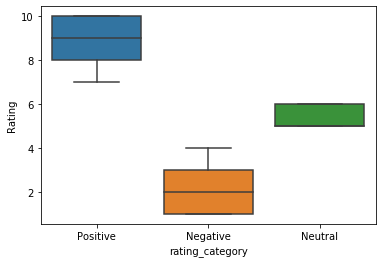

In [4]:
sns.boxplot(x=df_merge['rating_category'],y=df_merge['Rating'])

In [5]:
## only need to remove punctuation and stemize
stemmer = SnowballStemmer('english')

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_merge['Reviews'], df_merge['rating_category'], test_size=0.33, random_state=1)

# TF-IDF Vectorizer

In [7]:
# Generate table of words with their counts
# TfidfVectorizer transform train and test
con_vec = TfidfVectorizer(stop_words='english',tokenizer=tokenize,max_features=20000,ngram_range=(1,2))
X_train_tfidf = con_vec.fit_transform(X_train)
# with open("tfidf_vectorizer.pkl", 'wb') as handle:
#                     pickle.dump(con_vec, handle)
y_train_tfidf = y_train
X_test_tfidf = con_vec.transform(X_test)
y_test_tfidf = y_test


/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [14]:
print("Training set size",X_train_tfidf.shape)
print("Test set size",X_test_tfidf.shape)
print("=====================================")
print("Sentiment distribution in Test set: ")
print(y_test_tfidf.value_counts())

Training set size (226015, 20000)
Test set size (111322, 20000)
Sentiment distribution in Test set: 
Positive    70610
Negative    23726
Neutral     16986
Name: rating_category, dtype: int64


In [20]:
joblib.dump(con_vec, 'tfidf_vectorizer.pkl')

['tfidf_Vectorizer.pkl']

# Logistic Regression with TF-IDF Vectorizer

In [23]:
lr_tfidf = LogisticRegression(penalty='l1', multi_class='ovr',solver='saga',n_jobs=-1)
lr_tfidf.fit(X_train_tfidf,y_train_tfidf)
filename = 'logistic_reg_tf_idf.sav'
pickle.dump(lr_tfidf, open(filename, 'wb'))

/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [8]:
lr_tfidf = pickle.load(open('logistic_reg_tf_idf.sav', 'rb'))
lr_pred_tfidf = lr_tfidf.predict(X_test_tfidf)

In [9]:
accuracy_score(y_test_tfidf,lr_pred_tfidf)

0.7275201667235587

In [12]:
print("F1-score: ",f1_score(y_test_tfidf, lr_pred_tfidf, average='micro'))

0.7275201667235587

In [29]:
print("Accuracy on training set: {}".format(lr_tfidf.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(lr_tfidf.score(X_test_tfidf, y_test_tfidf)))
lr_cm = confusion_matrix(y_test_tfidf, lr_pred_tfidf)

Accuracy on training set: 0.7552905780589784
Accuracy on test set: 0.7275201667235587


In [53]:
print(lr_tfidf.predict(con_vec.transform(["The Actavis generic version of this medication was worse than useless, as all of the ADHD hyperactive subtype symptoms my son was experiencing returned within a week of switching to this from the Intuniv ER brand (daily 2mg dose), along with new and potentially dangerous side-effects.  His symptoms had been well-controlled for years prior to the insurance company insisting that we try a generic before they would continue to cover the cost of the brand."])))

['Negative']


In [36]:
print(lr_tfidf.predict(con_vec.transform(["Intuniv has made a huge change in my sons attitude.  After being on Strattera for 1.5 years, it stopped working.  It may have been due to a growth spurt, but the sudden change was awful. Intuniv has made a tremendous change and is working.  Intuniv is time released and 1 mg/day does the trick.  I am having to play the insurance game to get it approved and currently have a discount card that sells it for $63.It works great for my son and is worth every dollar it cost."])))

['Positive']


In [39]:
print(lr_tfidf.predict(con_vec.transform(["I must say I have been through a lot of medicines. Wasted money but most of all watching my kid struggle with his high anxiety and his inability to focus or sit down. He now focus better in school and his teacher describes him as on task now and takes time to ask her questions if needed. I had a lot of nights crying thinking I was a bad mother! I would lose control and not be able to handle his constant stubbornness and defiance he is a beautiful energetic boy with an amazing personality but just needed to be taken down a few notches. This has done the trick. I started off on 1 mg and did not seem to do to much and after three months decided to move to 2. I tried all natural nothing worked. Good luck."])))

['Positive']


In [41]:
print(lr_tfidf.predict(con_vec.transform(["My son was on this medication for 3 weeks.  3 weeks of pure HELL.  He became extremely violent to the point of trying to pull knives on his  brother.  I am not new to the world of bipolar for I have two sons who suffer with it, one being hospitalized over 10 times in 11 months.  This medication was not the right choice for my son, I am sad to say."])))

['Negative']


In [42]:
print(lr_tfidf.predict(con_vec.transform(["bet drug in years - just a nice feeling of normal - let's hope it stays!"])))

['Positive']


In [44]:
print(lr_tfidf.predict(con_vec.transform(["It's an ok drug for me, but I suffer Manic depression and bipolar plus severe mood swing. Recently I been hearing noises in my head stop taking cymbolta now taking rispadol. Not sure if will work my worst fear is gaining weight. And to stop all my med. Jessiehu"])))

['Neutral']


In [50]:
print(lr_tfidf.predict(con_vec.transform(["on the two week mark... a very serious problem started to occur.. i was angry all the time.. i lost my ability to process anything.. i would say really mean/nasty things to my bf in my sleep.. the rage would get worse each day to the point my bf was scared for his life.. and i couldnt go anywhere along.. cause the smallest thing said to me.. i would seriously injure someone.. i had no fear, no thought process of consequences.. i was scared for other people.. i was in such a dark place.. i never want to be that again.. i have been hospitalized twice in the last 4 years from worsening bipolar symptoms.. and i just had a severe adverse reaction.. i stopped immediately.. instantly the next morning.. i felt like new.."])))

['Negative']


# Random Forests with TF-IDF Vectorizer

In [30]:
clf_rfc = RandomForestClassifier(n_estimators=20).fit(X_train_tfidf, y_train_tfidf)

filename = 'random_forest_tf_idf.sav'
#pickle.dump(clf_rfc, open(filename, 'wb'))
clf_rfc = pickle.load(open(filename, 'rb'))
pred_rf = clf_rfc.predict(X_test_tfidf)

print("Accuracy on training set: {}".format(clf_rfc.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(clf_rfc.score(X_test_tfidf, y_test_tfidf)))
rf_cm = confusion_matrix(pred_rf, y_test_tfidf)

Accuracy on training set: 0.9928234851669137
Accuracy on test set: 0.7829090386446524


In [16]:
filename = 'random_forest_tf_idf.sav'
clf_rfc = pickle.load(open(filename, 'rb'))
pred_rf = clf_rfc.predict(X_test_tfidf)
print("F1-score: ",f1_score(y_test_tfidf, pred_rf, average='micro'))

0.7829090386446523

# XGBoost with TF-IDF Vectorizer

In [24]:
import xgboost as xgb
import sklearn
from sklearn.model_selection import RandomizedSearchCV

params_random_search = {
    'learning_rate': np.arange(0.01, 1.01, 0.01),
    'n_estimators': [200],
    'max_depth': range(2, 12),
    'subsample': np.arange(0.02, 1.02, 0.02)
}

clf_xgb = xgb.XGBClassifier(objective='multi:softmax',n_estimators=200,max_depth=7,learning_rate=0.99)

# randomized_mse = RandomizedSearchCV(param_distributions=params_random_search, estimator=clf_xgb,
#                                     scoring="neg_log_loss", n_iter=5, cv=3, verbose=1, iid=True)

# randomized_mse.fit(X_train_tfidf, y_train_tfidf)
clf_xgb.fit(X_train_tfidf, y_train_tfidf)

filename = 'xgboost_tf_idf.sav'
#print("Best parameters found: ", randomized_mse.best_params_)
#Best parameters found:  {'subsample': 0.7000000000000001, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.99}


#print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))
#pickle.dump(clf_xgb, open(filename, 'wb'))
#clf_xgb = pickle.load(open(filename, 'rb'))
pred_xgb = clf_xgb.predict(X_test_tfidf)

print("Accuracy on training set: {}".format(clf_xgb.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(clf_xgb.score(X_test_tfidf, y_test_tfidf)))
xgb_cm = confusion_matrix(pred_xgb, y_test_tfidf)

Accuracy on training set: 0.8526823440922062
Accuracy on test set: 0.7433930400100609


In [17]:
filename = 'xgboost_tf_idf.sav'
clf_xgb = pickle.load(open(filename, 'rb'))
pred_xgb = clf_xgb.predict(X_test_tfidf)
print("F1-score: ",f1_score(y_test_tfidf, pred_xgb, average='micro'))

0.7185911140655037

# SVM with TF-IDF Vectorizer

In [21]:
clf_svc = LinearSVC(max_iter = 2000).fit(X_train_tfidf, y_train_tfidf)

pred_svm = clf_svc.predict(X_test_tfidf)

print("Accuracy on training set: {}".format(clf_svc.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(clf_svc.score(X_test_tfidf, y_test_tfidf)))
svm_cm = confusion_matrix(pred_svm, y_test_tfidf)
print("F1-score: ",f1_score(y_test_tfidf, pred_svm, average='micro'))

Accuracy on training set: 0.784178041280446
Accuracy on test set: 0.7276818598300426
F1-score:  0.7276818598300426


# SGD Classifier with TF-IDF Vectorizer

In [22]:
clf_sgd = SGDClassifier(max_iter = 2000).fit(X_train_tfidf, y_train_tfidf)

pred_sgd = clf_sgd.predict(X_test_tfidf)

print("Accuracy on training set: {}".format(clf_sgd.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(clf_sgd.score(X_test_tfidf, y_test_tfidf)))
sgd_cm = confusion_matrix(pred_sgd, y_test_tfidf)
print("F1-score: ",f1_score(y_test_tfidf, pred_sgd, average='micro'))

Accuracy on training set: 0.7038426653098245
Accuracy on test set: 0.6972386410592695
F1-score:  0.6972386410592695


# Naive Bayes with TF-IDF Vectorizer

In [23]:
clf_nb = MultinomialNB(alpha=0.01).fit(X_train_tfidf, y_train_tfidf)

pred_nb = clf_nb.predict(X_test_tfidf)

print("Accuracy on training set: {}".format(clf_nb.score(X_train_tfidf, y_train_tfidf)))
print("Accuracy on test set: {}".format(clf_nb.score(X_test_tfidf, y_test_tfidf)))
nb_cm = confusion_matrix(pred_nb, y_test_tfidf)
print("F1-score: ",f1_score(y_test_tfidf, pred_nb, average='micro'))

Accuracy on training set: 0.7191159878769108
Accuracy on test set: 0.7052514327805824
F1-score:  0.7052514327805824


# Plot Confusion Matrix

/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


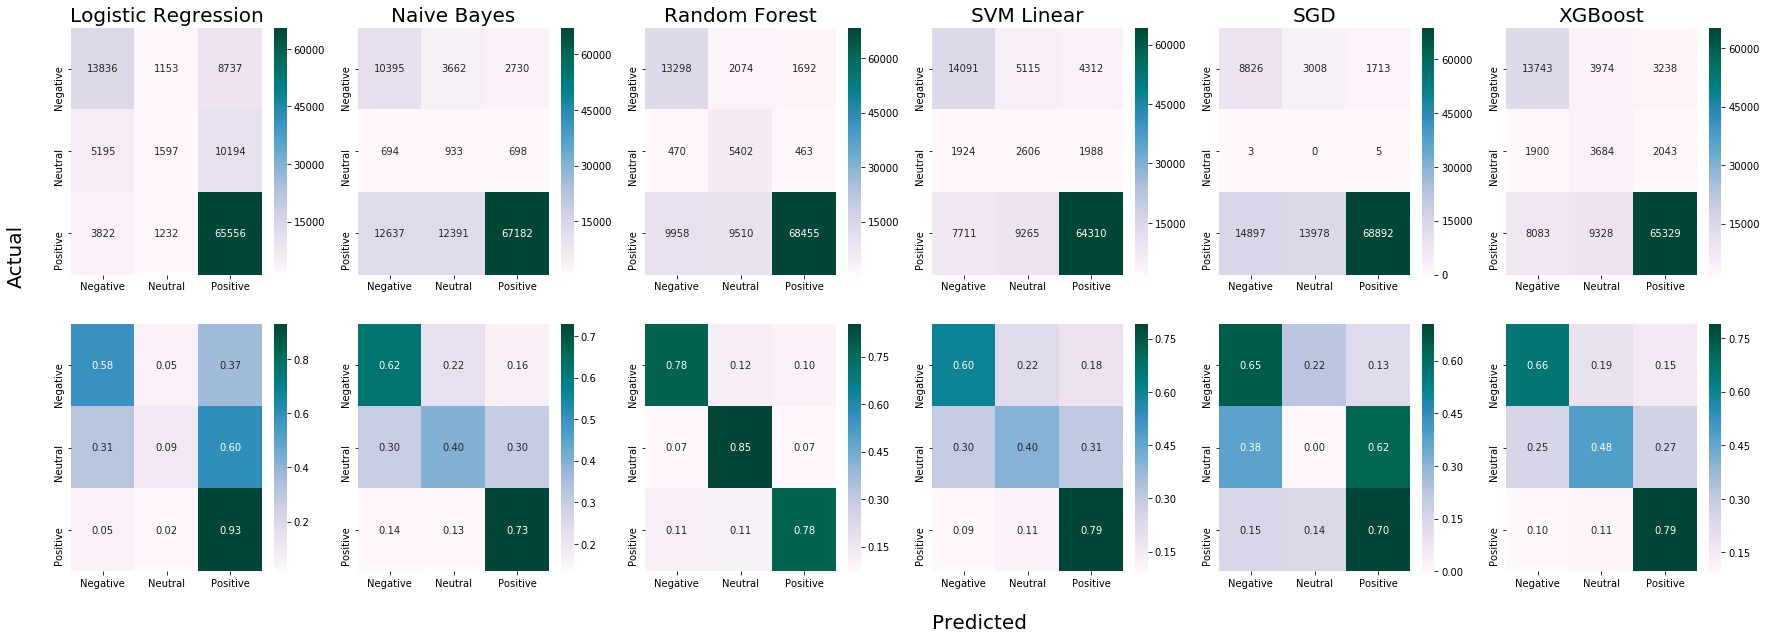

In [38]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_confusion_matrix_subplots(conf_mat,ax1,ax2,cbar=True):
    conf_mat_percentage = conf_mat/(conf_mat.sum(1).reshape(-1,1))

    conf_mat = pd.DataFrame(conf_mat,index=['Negative','Neutral','Positive'],columns=['Negative','Neutral','Positive'])
    conf_mat_percentage = pd.DataFrame(conf_mat_percentage,index=['Negative','Neutral','Positive'],columns=['Negative','Neutral','Positive'])
    
    sns.heatmap(conf_mat, annot=True,fmt="d",cmap="PuBuGn",cbar=cbar,ax=ax1)
    sns.heatmap(conf_mat_percentage, annot=True,fmt=".2f",cmap="PuBuGn",cbar=cbar,ax=ax2)


fig, axes = plt.subplots(2, 6, figsize=(30,10))
plot_confusion_matrix_subplots(lr_cm,axes[0,0],axes[1,0])
plot_confusion_matrix_subplots(nb_cm,axes[0,1],axes[1,1])
plot_confusion_matrix_subplots(rf_cm,axes[0,2],axes[1,2])
plot_confusion_matrix_subplots(svm_cm,axes[0,3],axes[1,3])
plot_confusion_matrix_subplots(sgd_cm,axes[0,4],axes[1,4])
plot_confusion_matrix_subplots(xgb_cm,axes[0,5],axes[1,5])
axes[0,0].set_title("Logistic Regression",fontsize=20)
axes[0,1].set_title("Naive Bayes",fontsize=20)
axes[0,2].set_title("Random Forest",fontsize=20)
axes[0,3].set_title("SVM Linear",fontsize=20)
axes[0,4].set_title("SGD",fontsize=20)
axes[0,5].set_title("XGBoost",fontsize=20)
plt.text(-23.5,-0.5,"Actual",fontsize=20,rotation=90)
plt.text(-9,3.7,"Predicted",fontsize=20)
plt.tight_layout()
plt.savefig("confusion_matrix_ml_models.png")

# Deep Neural Network : MLP (Multilayer Perceptron)

In [95]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Bidirectional, LSTM, BatchNormalization, Dropout
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [110]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(256,input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

# Model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
# Transform y to 3 categories using get_dummies()
y_train = pd.get_dummies(y_train_tfidf)
y_test = pd.get_dummies(y_test_tfidf)
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
hist = model.fit(X_train_tfidf, y_train, epochs=20, batch_size=128,validation_split=0.4, callbacks=callbacks_list, verbose=False)

model.save('sequential_model.h5')


Epoch 00001: val_accuracy improved from -inf to 0.82471, saving model to best_weights.hdf5

Epoch 00002: val_accuracy improved from 0.82471 to 0.82983, saving model to best_weights.hdf5

Epoch 00003: val_accuracy improved from 0.82983 to 0.83029, saving model to best_weights.hdf5

Epoch 00004: val_accuracy did not improve from 0.83029

Epoch 00005: val_accuracy did not improve from 0.83029

Epoch 00006: val_accuracy did not improve from 0.83029

Epoch 00007: val_accuracy did not improve from 0.83029

Epoch 00008: val_accuracy did not improve from 0.83029

Epoch 00009: val_accuracy did not improve from 0.83029

Epoch 00010: val_accuracy did not improve from 0.83029

Epoch 00011: val_accuracy did not improve from 0.83029

Epoch 00012: val_accuracy did not improve from 0.83029

Epoch 00013: val_accuracy did not improve from 0.83029

Epoch 00014: val_accuracy did not improve from 0.83029

Epoch 00015: val_accuracy did not improve from 0.83029

Epoch 00016: val_accuracy did not improve fro

In [133]:
from keras.models import load_model
seq_model = load_model('sequential_model.h5')

In [123]:
loss_and_accuracy = seq_model.evaluate(X_test_tfidf, y_test, batch_size=64)
print('loss_and_accuracy : ' + str(loss_and_accuracy))

111322/111322 [==============================] - 12s 107us/step
loss_and_accuracy : [0.7133438896686114, 0.8278539180755615]


### Accuracy vs Loss Plot 

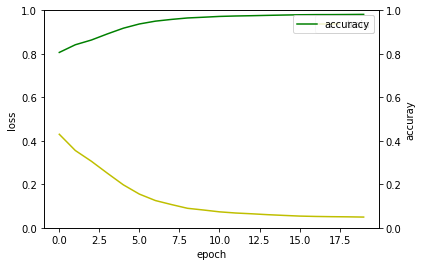

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'],'y', label='train')
acc_ax.plot(hist.history['accuracy'],'g', label='accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper right')
acc_ax.legend(loc='upper right')



### Sequential Model Predictions (Sentiment Distribution)

In [ ]:
preds_seq = seq_model.predict_classes(X_test_tfidf)

In [150]:
np.unique(preds_seq,return_counts=True)

(array([0, 1, 2]), array([28268,  9785, 73269]))

### Sentiment Prediction on few reviews from original dataset

#### 0 --> Negative , 1 --> Neutral , 2 --> Positive

In [107]:
seq_model.predict_classes(con_vec.transform(["hello"]))

array([1])

In [125]:
seq_model.predict_classes(con_vec.transform(["I only took this medication for about a week due to the difficulty I had sleeping after starting it. "]))

array([1])

In [163]:
seq_model.predict_classes(con_vec.transform(["very bad"]))

array([0])

In [127]:
seq_model.predict_classes(con_vec.transform(["We began with night wakings then more aggression. He was never aggressive like this before. Raised to 2 mg symptoms increased again. Still hyper and seemed worse than before. Upon reducing back to 1 mg to none it&#039;s been a nightmare. Red red cheeks. Bouncing off walls. Bouncing Up till 3 am. Starting to come down a bit but oh my god the havoc on his mind and body and us plus no sleep. Doc said there wouldn&#039;t be any withdrawal "]))

array([0])

In [128]:
seq_model.predict_classes(con_vec.transform(["It's an ok drug for me, but I suffer Manic depression and bipolar plus severe mood swing. Recently I been hearing noises in my head stop taking cymbolta now taking rispadol. Not sure if will work my worst fear is gaining weight. And to stop all my med. Jessiehu"]))

array([1])

In [130]:
seq_model.predict_classes(con_vec.transform(["I must say I have been through a lot of medicines. Wasted money but most of all watching my kid struggle with his high anxiety and his inability to focus or sit down. He now focus better in school and his teacher describes him as on task now and takes time to ask her questions if needed. I had a lot of nights crying thinking I was a bad mother! I would lose control and not be able to handle his constant stubbornness and defiance he is a beautiful energetic boy with an amazing personality but just needed to be taken down a few notches. This has done the trick. I started off on 1 mg and did not seem to do to much and after three months decided to move to 2. I tried all natural nothing worked. Good luck."]))

array([2])

In [131]:
seq_model.predict_classes(con_vec.transform(["We started my 5 yr old on this, the 1 worked for him for a few weeks, then we noted an increase in aggression and hyperactivity. They upped him to 2 mg and now he has not slept in days no more than 4 hours a night and then he wakes and starts kicking the door to his room and screams at the top of his lungs until we get him up, he has trashed his bedroom and said he noticed curtains moving when there are no movement. He is loud and violent and swearing, I called the DR right away after the first night of him saying his curtain rod was moving, so they said take it at night instead, but then waking up for a week at 3 am has been a nightmare. We are so stressed and over whelmed with this behavior he is out of control."]))

array([0])

In [165]:
seq_model.predict_classes(con_vec.transform(["Our son was diagnosed with ADD when he was in grade 5-he was started on vyvanse and after a few months and a dose increase developed psychotic episodes.  This experience scared the life out of me so we stopped the drug and revisited pharmaceuticals with our pediatrician.She suggested Intuniv and we tried it. Our son has been on the drug now for almost 4 years-he is on the max dose for his age (3 mg) (?) and I honestly can&#039;t see if there is a difference.  He has had no visible side effects-nothing like I have been reading about above. If anything he has put on weight (it is not a stimulant).We are going to try weaning him off in the next few months to see if there is a difference in schoolwork and to see if the med is really working."]))

array([0])

In [166]:
seq_model.predict_classes(con_vec.transform(["Had mierna for about 6 months. Was told that it would help my cysts disappear and it had little to no side effects. It was a great thing being that i got pregant with my son while on the pill. This was 5 years, check string, no periods, and all that. Well starting 2 months after having it in which would be july 2015 i started experiencing pain in my lower abdomen, back and my left leg/foot. It wasnt bad then every month from july 2015 until this month nov 2015 i was in more and more pain. No doctor could explain why. Finally decided to have it removed a few days ago. Best decision i made because the same day i started feeling better. All the pain was going away or gone. It's a good form of birth control but isnt for every women."]))

array([1])

In [167]:
seq_model.predict_classes(con_vec.transform(["Makes me feel bad all the time."]))

array([2])

In [135]:
seq_model.predict_classes(con_vec.transform(["placed on for 90 days and had to be cardioverted x2. Tried exercising and put me back into afib. Terrible diarrhea! twice day dosing and 5 dollars a pill! Too expensive for my taste"]))

array([0])

In [136]:
seq_model.predict_classes(con_vec.transform(["The extreme fatigue is awful, been on this drug for about 7 weeks and it gets worse the longer I am on it. Is this normal?"]))

array([0])

In [137]:
seq_model.predict_classes(con_vec.transform(["Does not work.  Gotten, lightheaded, dehydrated, nausea ,difficulty breathing.  Also had forgetfulness.  Am now scheduled for a Cardiac Ablation.  I sure hope it helps."]))

array([0])

In [138]:
seq_model.predict_classes(con_vec.transform(["Currently I am taking 80mg twice a day.  I started out with 120mg twice a day, but Dr reduced dosage after a while.  I have been aking Sotalol since July 2010 and have not any more rapid heart beat (AFIB) nor suffered any other adverse side affect. from this medication."]))

array([2])

In [139]:
seq_model.predict_classes(con_vec.transform(["A fib is no fun. I tried other drugs but this one is the one that is working. "]))

array([2])

In [140]:
seq_model.predict_classes(con_vec.transform(["when i strated taking the medication i was fine. i was taking my diuretic in the evening and isoniazid at 11:25am. i noticed that just about 1 hour or so before my next dosage i would become dizzy and weak. about an hour or so after taking it i would be myself again. but i didn't felt comfortable i felt to tired and weak. i went to my doctor and took me off the medication. in 2 wks im supposed to go back and get another medicine and im praying to GOD that everything goes well the 2nd time around. i really dont know if this is ok but i guess the doctors didnt want to take a risk. the doctor even told me that it was not a common symptom but that i had to get off the medication. i hope all goes well. "]))

array([0])

In [141]:
seq_model.predict_classes(con_vec.transform(["I AM HAVING A JERKING REACTION IN MY BODY, I EVEN CAN FEEL IT IN MY HEAD,MY MOUTH JURKES OPEN WHEN I DON'T WANT TO,IN MY HEAD I FEEL A JERKING.PLEASE HELP!MY DOCTOR SAYS TAKE, IT DON'T CAUSE THIS.THE BOTTLE SAYS IT MESS WITH YOUR NERVIOUS SYSTEM.WHAT CAN I DO?"]))

array([0])

# LightGBM

In [ ]:
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier


#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
# target = df_train['sentiment']
# feats = ['usefulCount']

#sub_preds = np.zeros(df_test.shape[0])

x_train, x_test, Y_train, Y_test = train_test_split(df_merge['Reviews'], df_merge['rating_category'], test_size=0.2, random_state=42) 
#feature_importance_df = pd.DataFrame() 
    
clf_lgbm = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf_lgbm.fit(x_train, Y_train, verbose=100, early_stopping_rounds=100)

preds_lgbm = clf_lgbm.predict(x_test)

print("Accuracy on training set: {}".format(clf_lgbm.score(x_train, Y_train)))
print("Accuracy on test set: {}".format(clf_lgbm.score(x_test, Y_test)))
print("Confusion Matrix")
print(confusion_matrix(preds_lgbm, Y_test))
        
# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Hashing Vectorizer

In [24]:
from sklearn.feature_extraction.text import HashingVectorizer
text_data = df_merge['Reviews']
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'
hashing_vect = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC, stop_words='english', n_features=200000, norm=None, binary=False, ngram_range=(1,2))
hashed_text = hashing_vect.fit_transform(text_data)
hashed_df = pd.DataFrame(hashed_text.data)
hashed_text.shape

(337337, 200000)

In [25]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(hashed_text, df_merge['rating_category'], random_state=42, stratify=df_merge['rating_category'])

# Logistic Regression with Hashing Vectorizer

In [28]:
clf_lr_hash = LogisticRegression(penalty='l2', solver='lbfgs',max_iter=2000).fit(X_train_h, y_train_h)

filename = 'logistic_reg_hash.sav'
pickle.dump(clf_lr_hash, open(filename, 'wb'))
#pickle.load(open(filename, 'rb'))
pred_lr_hash = clf_lr_hash.predict(X_test_h)

print("Accuracy on training set: {}".format(clf_lr_hash.score(X_train_h, y_train_h)))
print("Accuracy on test set: {}".format(clf_lr_hash.score(X_test_h, y_test_h)))
lr_cm_hash = confusion_matrix(pred_lr_hash, y_test_h)
print("F1-score: ",f1_score(y_test_h, pred_lr_hash, average='micro'))

/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy on training set: 0.9605813392779504
Accuracy on test set: 0.7728701013813957
F1-score:  0.7728701013813957


# Logistic Regression CV with Hashing Vectorizer

In [29]:
clf_lr_cv = LogisticRegressionCV(cv=3,max_iter=2000,random_state=123).fit(X_train_h, y_train_h)

filename = 'logistic_reg_hash_cv.sav'
pickle.dump(clf_lr_cv, open(filename, 'wb'))
#pickle.load(open(filename, 'rb'))
pred_lr_cv = clf_lr_cv.predict(X_test_h)

print("Accuracy on training set: {}".format(clf_lr_cv.score(X_train_h, y_train_h)))
print("Accuracy on test set: {}".format(clf_lr_cv.score(X_test_h, y_test_h)))
lr_cv_cm = confusion_matrix(pred_lr_cv, y_test_h)
print("F1-score: ",f1_score(y_test_h, pred_lr_cv, average='micro'))

/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/darklord/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:94

Accuracy on training set: 0.9238780721101019
Accuracy on test set: 0.7674512361415782
F1-score:  0.7674512361415781


# Random Forests with Hashing Vectorizer

In [32]:
clf_rfc_hash = RandomForestClassifier(n_estimators=10).fit(X_train_h, y_train_h)

filename = 'random_forest_hash.sav'
pickle.dump(clf_rfc_hash, open(filename, 'wb'))
#pickle.load(open(filename, 'rb'))
pred_rf_hash = clf_rfc_hash.predict(X_test_h)

print("Accuracy on training set: {}".format(clf_rfc_hash.score(X_train_h, y_train_h)))
print("Accuracy on test set: {}".format(clf_rfc_hash.score(X_test_h, y_test_h)))
rf_cm_hash = confusion_matrix(pred_rf_hash, y_test_h)
print("F1-score: ",f1_score(y_test_h, pred_rf_hash, average='micro'))

Accuracy on training set: 0.983411198330448
Accuracy on test set: 0.7788106954408016
F1-score:  0.7788106954408016


# SVM with Hashing Vectorizer

In [34]:
clf_svc_hash = LinearSVC(max_iter = 2000).fit(X_train_h, y_train_h)

pred_svm_hash = clf_svc_hash.predict(X_test_h)

print("Accuracy on training set: {}".format(clf_svc_hash.score(X_train_h, y_train_h)))
print("Accuracy on test set: {}".format(clf_svc_hash.score(X_test_h, y_test_h)))
svm_cm_hash = confusion_matrix(pred_svm_hash, y_test_h)
print("F1-score: ",f1_score(y_test_h, pred_svm_hash, average='micro'))

Accuracy on training set: 0.9865060355254108
Accuracy on test set: 0.7552380387739372
F1-score:  0.7552380387739372
